In [23]:
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models
from torch import nn, optim

# VGG16 model (Base model)

In [3]:
class BaseModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.build_network()

    def build_network(self):
        self.vgg16_model = models.vgg16(pretrained=True).features
        self.vgg16_model.eval()

        self.network = nn.Sequential(
            nn.AdaptiveAvgPool2d([1,1]),
            nn.Flatten(1),
            nn.Linear(512,2)
        )
    
    def forward(self, x):
        x = self.vgg16_model(x)
        y = self.network(x)
        return y

In [4]:
model = BaseModel()

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
x = torch.rand([64,3,256,256])

In [6]:
model(x).shape

torch.Size([64, 2])

# VGG16 with Grad-CAM

In [10]:
class VGG16GradCAM(nn.Module):
    def __init__(self):
        super().__init__()
        self.build_network()
        
    def build_network(self):
        # VGG16 모델 불러오기 (사전 훈련된)
        self.vgg16_model = models.vgg16(pretrained=True).features
        self.vgg16_model.eval()
        
        self.network = nn.Sequential(
            nn.AdaptiveAvgPool2d([1,1]),
            nn.Flatten(1),
            nn.Linear(512,2)
        )
        self.gradients = None
    

    # 훅(hook) 등록을 위한 함수
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.vgg16_model(x)

        # 특성 맵에 대한 그래디언트를 저장하기 위한 훅 등록
        h = x.register_hook(self.activations_hook)

        y = self.network(x)
        return y

    # Grad-CAM 처리 함수
    def generate_cam(self, input_image, class_idx):
        # 모델의 예측값과 그래디언트를 얻기 위한 forward pass
        model_output = self.forward(input_image)
        model_output[:, class_idx].backward()

        gradients = self.gradients.data
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = self.vgg16_model(input_image).data

        activations *= pooled_gradients[None, :, None, None]

        heatmap = torch.mean(activations, dim=1)
        heatmap = torch.clamp(heatmap, min=0)
        heatmap /= torch.max(heatmap)

        # # 모델의 예측값과 그래디언트를 얻기 위한 forward pass
        # model_output = self.forward(input_image)
        # model_output[:, class_idx].backward()

        # # 그래디언트와 특성 맵을 가져옴
        # gradients = self.gradients.data[0]
        # pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        # activations = self.features_conv(input_image).data[0]

        # # 각 특성 맵을 그래디언트로 가중치를 둠
        # for i in range(activations.shape[0]):
        #     activations[i, :, :] *= pooled_gradients[i]

        # # 평균을 취해 최종 히트맵 생성
        # heatmap = torch.mean(activations, dim=0)
        # heatmap = torch.clamp(heatmap, min=0)
        # heatmap /= torch.max(heatmap)
        return heatmap


In [11]:
# 메인 실행 함수
image = torch.rand([1,3,256,256])  # 이미지 경로
class_idx = 0  # 클래스 인덱스 (예를 들어, ImageNet의 클래스 인덱스)

# 모델 및 Grad-CAM 인스턴스 생성
grad_cam = VGG16GradCAM()

# Grad-CAM 실행
heatmap = grad_cam.generate_cam(image, class_idx)
heatmap.shape

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 8, 8])

In [12]:
y_pred = grad_cam(image)
y_pred.shape

torch.Size([1, 2])

In [13]:
heatmap = np.maximum(heatmap, 0)
heatmap = heatmap / heatmap.max()
heatmap.shape

torch.Size([1, 8, 8])

In [14]:
img = np.array(image)[0].transpose(1,2,0)
heatmap = np.uint8(255 * heatmap)
heatmap = np.uint8(Image.fromarray(heatmap[0]).resize((img.shape[0], img.shape[1])))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap.shape

(256, 256, 3)

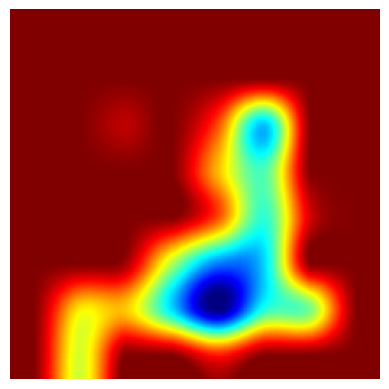

In [15]:
alpha = 1
superimposed_img = heatmap * alpha + img
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

plt.imshow(superimposed_img)
plt.axis('off')
plt.show()

# Conv-Att model

Init signature:
nn.TransformerEncoderLayer(
    d_model: int,
    nhead: int,
    dim_feedforward: int = 2048,
    dropout: float = 0.1,
    activation: Union[str, Callable[[torch.Tensor], torch.Tensor]] = <function relu at 0x7f378ace8160>,
    layer_norm_eps: float = 1e-05,
    batch_first: bool = False,
    norm_first: bool = False,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
TransformerEncoderLayer is made up of self-attn and feedforward network.
This standard encoder layer is based on the paper "Attention Is All You Need".
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
in a different way during application.

TransformerEncoderLayer can handle either traditional torch.tensor inputs,
or Nested Tensor inputs.  Derived classes are expected 

In [59]:
class ConvAttnModel(nn.Module):
    def __init__(self, h_dim_attn, n_heads, h_dim_fc, n_layers, vgg16_freezing=True):
        super().__init__()
        self.h_dim_attn = h_dim_attn
        self.build_network(n_heads, h_dim_fc, n_layers, vgg16_freezing)
        
    def build_network(self, n_heads, h_dim_fc, n_layers, vgg16_freezing):
        # VGG16 모델 불러오기 (사전 훈련된)
        self.vgg16_model = models.vgg16(pretrained=True).features
        if vgg16_freezing:
            self.vgg16_model.eval()
        vgg_out_channels = self.vgg16_model[-3].out_channels
        self.conv_1x1 = nn.Conv2d(vgg_out_channels, h_dim_attn, 1)

        enc_layer = nn.TransformerEncoderLayer(self.h_dim_attn, n_heads, h_dim_fc, batch_first=True)    
        self.attn = nn.TransformerEncoder(enc_layer, n_layers)    

        self.network = nn.Sequential(
            nn.Linear(self.h_dim_attn, 2)
        )
    
    def forward(self, x):
        x_tilde = self.vgg16_model(x) # (B, C, H, W)
        x_tilde = self.conv_1x1(x_tilde) # (B, D, H, W)

        _x_tilde = x_tilde.flatten(2).permute(0,2,1) #(B, HW, D)
        cls_rand_token = torch.randn(_x_tilde.shape[0], 1, self.h_dim_attn) #(B, 1, D)
        x_tilde_cls = torch.cat([_x_tilde, cls_rand_token], 1) # (B, HW+1, D)
        x_attn = self.attn(x_tilde_cls) # (B, HW+1, D)

        x = x_attn[:,-1] #(B, D)
        y = self.network(x)
        return y


In [60]:
x = torch.rand([16,3,256,256])

In [61]:
h_dim_attn = 128
n_heads = 1
h_dim_fc = 512
n_layers = 1

In [62]:
model = ConvAttnModel(h_dim_attn, n_heads, h_dim_fc, n_layers)

/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/root/miniconda3/envs/cdt/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [63]:
model(x).shape

torch.Size([16, 2])

In [17]:
backbone = vgg16.features

In [18]:
x_tilde = backbone(x)
x_tilde.shape

torch.Size([16, 512, 8, 8])

In [19]:
h_dim_attn = 128

In [21]:
cls_rand_token = torch.randn(16,h_dim_attn)
cls_rand_token.shape

torch.Size([16, 128])

In [25]:
conv_1x1 = nn.Conv2d(512, h_dim_attn, 1)
conv_1x1

Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))

In [27]:
x = conv_1x1(x_tilde)
x.shape

torch.Size([16, 128, 8, 8])

In [28]:
x = x.flatten(2)
x.shape

torch.Size([16, 128, 64])

In [32]:
x = torch.cat([x, cls_rand_token[...,None]], -1)
x.shape

torch.Size([16, 128, 65])